In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prepare import wrangle_data, split_data
import explore
import model

import warnings 
warnings.filterwarnings('ignore')

target = 'newconstructionyn'

**Note** all code for this project can be found in the Github repository at github.com/bensmith07/new_construction

# Project Description

This project uses a labeled set of MLS listings from San Antonio, TX and attempts to build a model that will identify which of those listings are new construction and which are not. For a company which aims to provide the most accurate Automated Valuation Model (AVM) on the market, the utility of such a prediction is obvious. The market for new construction is likely to be different than that of existing homes, and we should expect a requisite difference in value between a newly constructed home and a similar home which has been previously owned. 

#### Assumptions

For the purposes of this analysis, I have made the assumption that the ultimate goal for the model will be to identify new construction for a new listing (at the time the property is listed) rather than to retroactively identify new construction amidst a set of historical listings. 

I have also made the assumption that the model should be generalizable to other metropolitan areas. 

Based on these assumptions, I removed data which:
- A) would not be available or would be irrelevant at the time a property is first listed on the MLS
- B) identified specific geographic localities

I also assume that the ultimate goal is to identify as many new construction listings as possible, and to avoid letting a new construction listing go by unnoticed. This assumption affected the metric by which I chose to evaluate predictive models. 

#### Goals

- 1) Create a model to identify new construction vs. existing homes
- 2) Summarize the aggregate difference in price between new construction vs. existing homes

## Acquisition

This dataset came as a prepackaged CSV file containing the features shown below

In [2]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4780 entries, 0 to 4779
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   address_id                4780 non-null   int64  
 1   city                      4778 non-null   object 
 2   postal_code               4778 non-null   float64
 3   census_tract              4778 non-null   float64
 4   standardstatus            4780 non-null   object 
 5   mlsstatus                 4780 non-null   object 
 6   contractstatuschangedate  4780 non-null   object 
 7   purchasecontractdate      3922 non-null   object 
 8   closedate                 3508 non-null   object 
 9   listingcontractdate       4780 non-null   object 
 10  daysonmarket              4779 non-null   float64
 11  closeprice                3508 non-null   float64
 12  listprice                 4780 non-null   int64  
 13  originallistprice         4765 non-null   float64
 14  property

## Preparation

In order to clean and prepare this data, I performed the following steps:

**Removing Irrelevant or Un-Useful Data**

Including: 
- any column where there is only one unique value
- location specific data
- data unavailable/irrelevant at the time of a new listing

**Handling Missing Values**
- removing columns with an abundance of null values (`lotfeatures`, `totalactualrent`)
- imputing missing values for the following columns:
    - `garageyn` (imputed based on information found in `parkingfeatures` column
    - `stories` (imputed based on information found in `architecturalstyle` column
    - `lotsizearea` (imputed with the median)
    
**Adjusting Data Types**
- address_id: int >> string
- listingcontractdate: string >> Pandas Timestamp

**Data Cleaning**
- `propertysubtype`: combining category labels which likely have the same meaning ('Single Family Detached' and 'Single Family Residence Detached'
- `lotsizearea`: correcting negative lot size values (which were likely listed in error) by taking the absolute value

**Engineering New Features:**

including:

(for the sake of time, I have excluded explicit definitions of these features)
- listing_month
- listing_dayofmonth
- listing_dayofweek
- listed_on_weekend
- years_since_build
- built_last_two_years
- parkingfeatures_attached
- parkingfeatures_detached
- parkingfeatures_oversized
- parkingfeatures_converted
- parkingfeatures_sideentry
- parkingfeatures_rearentry
- parkingfeatures_tandem
- parkingfeatures_golfcart
- heating_central
- heating_naturalgas
- heating_electric
- heating_heatpump
- heating_2units
- heating_1unit
- heating_zoned
- heating_other
- heating_floorfurnace
- heating_solar
- heating_propaneowned
- heating_none
- heating_windowunit
- cooling_central
- cooling_winddowwall
- cooling_heatpump
- cooling_zoned
- central_cooling_units
- winddowwall_cooling_units
- archstyle_traditional
- archstyle_splitlevel
- archstyle_ranch
- archstyle_texashillcountry
- archstyle_craftsman
- archstyle_other
- archstyle_colonial
- archstyle_spanish
- archstyle_manufacturedhome-singlewide
- archstyle_a-frame
- lotsizearea_listed_negative
- lotsizearea_small
- originallistprice_persqft
- originallistprice_scaled
- originallistprice_scaled_persqft
- previously_listed

**For-Sale vs. For-Rent Listings**

Seeing that the `originallistprice` of For-Rent represents the monthly rent price, whereas in For-Sale listings it represents the purchase price, and that these two things are on entirely different scales, I created Min-Max scaled versions of the `originallistprice` and `originallistprice_persqft` column. 

However, the distributions of these scaled columns were still quite different from one another, with the rental properties having `originallistprice_persqft_scaled` values that were much more heavily concentrated around the mean.

Recognizing that this could have a negative affect on any modeling and analysis, I created two separate dataframes, one for rental listings and one for sale listings, which could be used to analyze or model these categories independent of each other, while also maintaining the original whole dataset in it's own dataframe variable. 

(Note: Analysis and modeling with the separate dataframes is a step I would take if given more time for this project, but this iteration of the project does not utilize these separate dataframes at this time)

In [3]:
# this function performs the preparation steps described above
df, sale_df, rent_df = wrangle_data()
# displaying info about the transformed dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4289 entries, 0 to 4288
Data columns (total 66 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   address_id                             4289 non-null   object        
 1   listingcontractdate                    4289 non-null   datetime64[ns]
 2   originallistprice                      4289 non-null   float64       
 3   propertytype                           4289 non-null   object        
 4   propertysubtype                        4289 non-null   object        
 5   lotsizearea                            4289 non-null   float64       
 6   bedroomstotal                          4289 non-null   float64       
 7   bathroomstotalinteger                  4289 non-null   float64       
 8   bathroomsfull                          4289 non-null   float64       
 9   bathroomshalf                          4289 non-null   float64 

**Splitting the Data**

Before examining interactions between various features and the target, I split the data into train and test sets, so as to avoid data leakage. 

In [4]:
train, test = split_data(df)

## Exploration

In this section, I look at individual features and various combinations of features and examine how they relate to the target variable of `newconstructionyn` in an attempt to identify which might be useful in identifying new construction listings. 

*Note:* For statistical rigor, hypothesis testing should be conducted on many of the exploratory findings shown here. For reasons of expediency, I did not perform statistical hypothesis tests as part of this analysis. 

### Build Year

The most obvious feature to examine when attempting to identify new construction in the year the structure was built. If that year  is recent, it seems fairly obvious that the property is more likley to be "new". There may be rare instances where a property has remained vacant for multiple years since it's construction, and there may be instances where a newly built home has it's build year input incorrectly in the listings, but these situations should be relatively rare. 

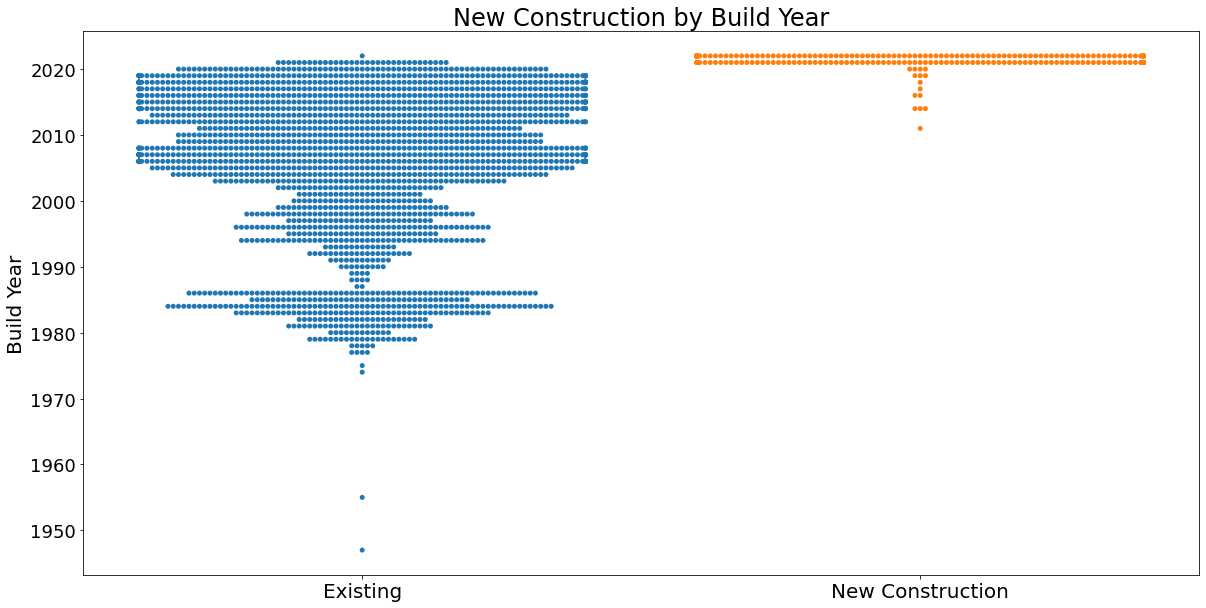

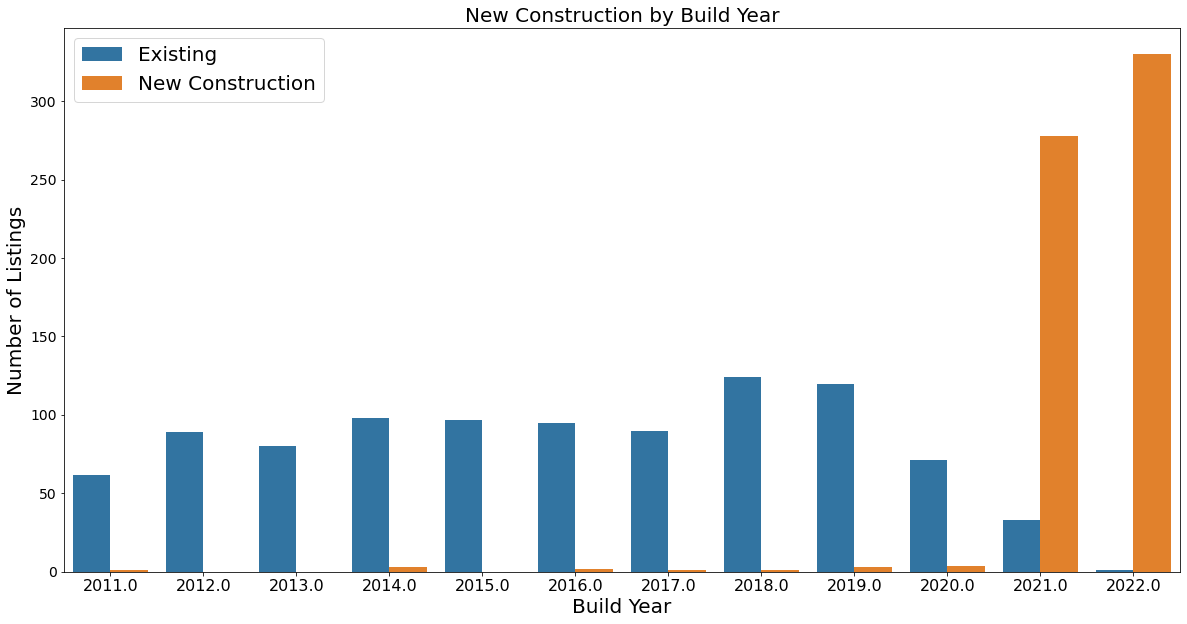

In [5]:
explore.build_year(train, target)

Here we can see that a build year of 2021 or 2022 is far more likely to be new construction, and that new construction is more likely to have a build year of 2021 or 2022. This makes sense, because our dataset consists of listings from 2021 and 2022. 

I also compared build year relative to the listing date, and created a binary column to determine if the build year was within two years of the listing date. 

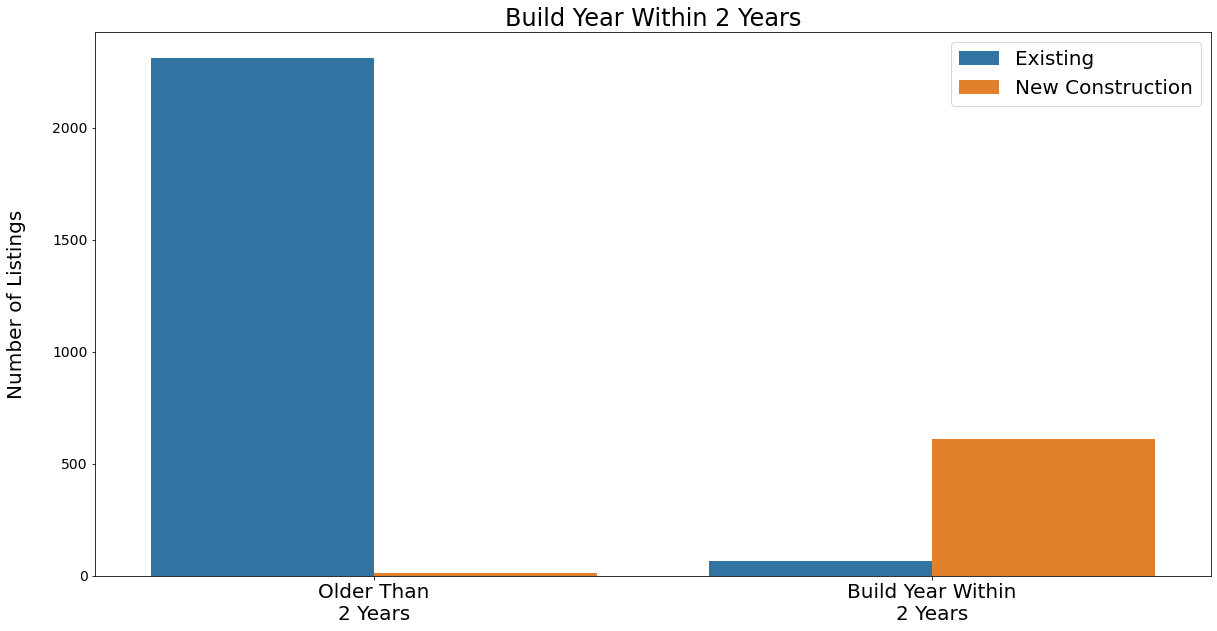

In [6]:
explore.built_last_two_years(train, target)

This leads me to believe that whether a property was built within two years of the listing date is likely to be the simplest, if not the most effective, way of determining whether the property is new construction.

### List Price

I'll hypothesize that new construction is generally more desirable, and will therefore have a higher price than a comparable home.

*Note:* Since the dataset includes both monthly rent prices and for-sale prices, these categories have each been scaled based on their respective min and max values. 

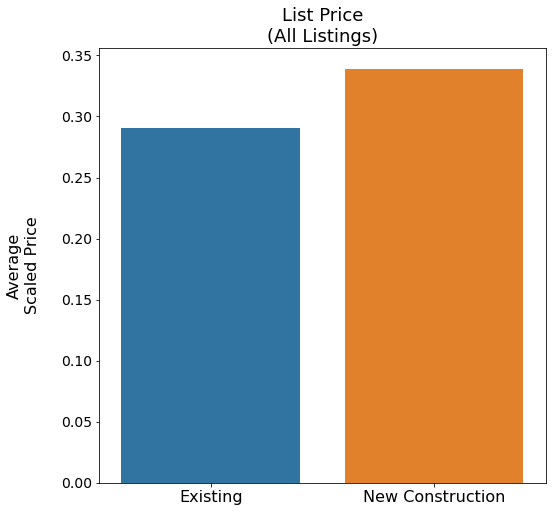

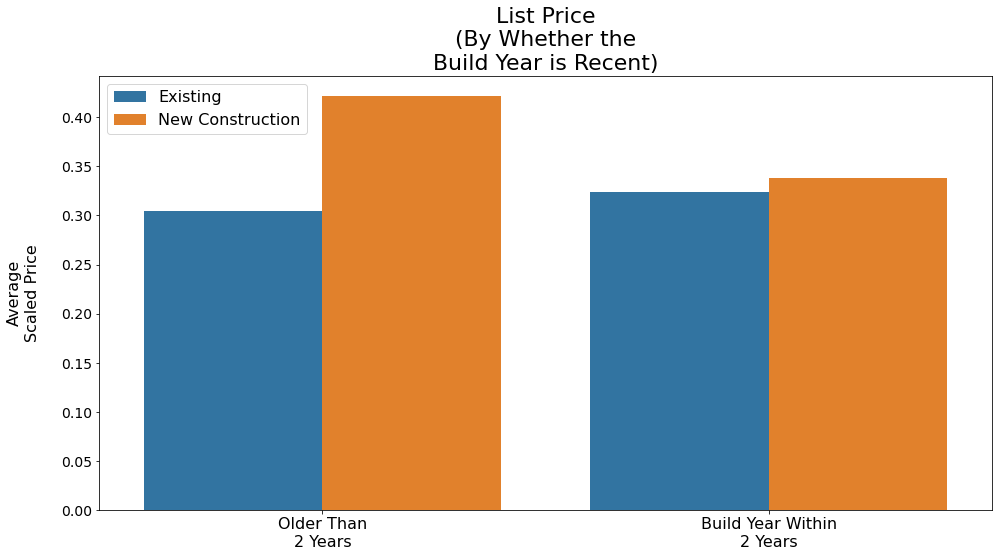

In [7]:
explore.list_price(train, target)

It does appear that new construction has a higher average list price, and that this holds true when controlling for whether the build year is recent. Though, the effect is lessened for recent build years, and it should be noted that there is a rather small sample size of new construction listings in older build years. 

(With a larger dataset (and more time) we could group similar houses by other features in addition to build year, and see if a newly constructed home still holds more value than an existing home within those groups.)

### List Price - Per SqFt

Here we make a similar comparison using the per-square-foot price

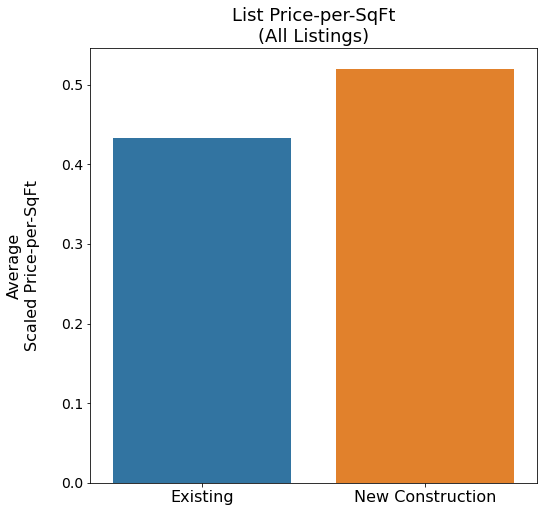

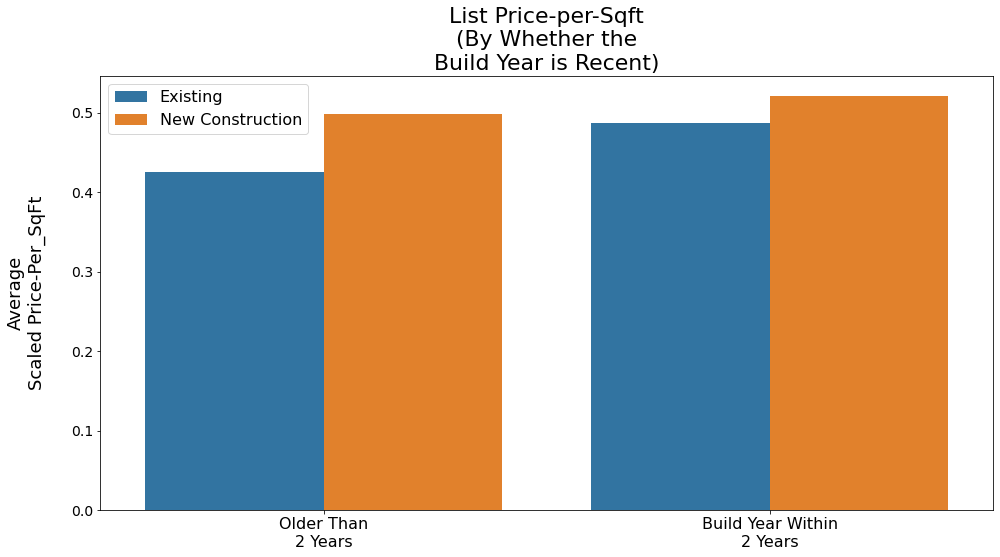

In [8]:
explore.list_price_persqft(train, target)

We see a very similar effect when comparing both the List Price and the List Price-per-SqFt between new construction vs existing homes. Since they are bound to be highly correlated, only one of these features should be included in any eventual model. I will choose to use the per-sqft price, since this is traditionally a better metric for comparing properties of differing size. 

### Previous Listings

It was observed that many of the properties (as identified by their `address_id`) had multiple listings in the dataset. One likely explanation from this is that the property was removed from the MLS and then placed back on the MLS shortly thereafter, without a transaction taking place. However, one other explanation is that the earlier listings for a property represent a previous transaction. In this case, by definition, the more recent transactions would not be "new construction". 

Therefore, I created a feature representing whether a property had a previous listing in the dataset, and hypothesize that new construction is less likely to have had a previous listing. 

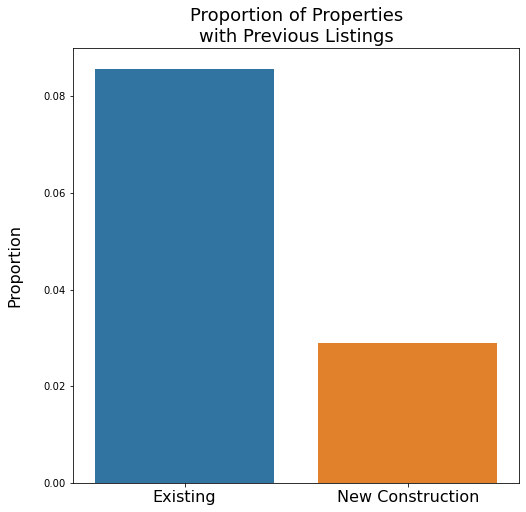

In [9]:
explore.previous_listings(train, target)

It does the appear that new construction is much less likely to have had a previous listing in the dataset, though from this analysis we cannot know whether that is because the property did in fact have a previous transaction, or for some other reason. A more reliable way of using such information would be to compare the listing to a larger set of data going back further historically. For example, if an address had a previous listing from 5-10 years ago, it is probably even less likely to be new construction. We are limited by this dataset from this kind of analysis, since the dataset spans only about 1 yaer. 

### Other Factors

Some other hypothesis were explored and found likely to be insignificant, so I will omit detailed visualizations from this report. Further information about these analyses can be found in the `explore_2.ipynb` in the drafts folder of this project's repository.

Some of the factors I considered were:
    
**Lot Size**

Does New Construction have a different average lot size than existing homes?

While it did appear at first glance that new construction had a smaller lot size on average, the difference appeared relatively weak. 

**Central Heating and Cooling**

One might assume that a new build would be much more likely than an older home to have a central HVAC system. However, there were so few observations at all which lacked central heating or cooling, that this did not appear to be a significant feature. 

**Window/Wall Units**

Similar to the central HVAC hypothesis discussed above, it seems new builds would be unlikely to have window/wall units. But very few homes at all in this dataset had them. 

**Garages**

One might notice driving around town that homes in some neighborhoods are more likely to have carports or other parking features than garages, and hypothesize that this is due to changing historical trends, and therefore new builds might be more (or less) likely to have a garage. But again, there were so few properties in the dataset without garages, that this did not appear to be a useful feature. 

**Others**

In a quick attempt to identify any other standout features or combinations of features, I used a seaborn pairplot, controlling for the target variable by changing it's color with the `hue` parameter. However, no major differences in new construction vs existing were visually apparent. 

## Modeling

### Prep for Modeling

This function drops columns which will not be used in modeling, then encodes, splits, and scales data as appropriate. 

In [10]:
train, test = model.prep_for_modeling(df)

Now I will attempt to use the information learned during exploration to create a model capable of identifying at the time a property is listed whether it is new construction. 

### Baseline Predictions

**Baseline 1**

Since the majority of properties are not new construction, the simplest baseline would be to predict that each property is not new construction. This will maximize the accuracy of our baseline predictions. 

**Baseline 2**

Since I assume the goal is to avoid letting new construction go by unnoticed, I will attempt to optimize for the recall metric. In this case, a better baseline would be to treat all properties as if they are new construction. 

**Model 1: A Simple 1-Feature Model**

Exploration found that our most reliable feature is whether the build year of the property is within two calendar years of the listing date. This is also very intuitive - any reasonable person looking at a listing and trying to guess whether it was new construction would look for a recent build year. If our eventual model cannot predict more reliably than that, it will not be of much use. Therefore, Model 1 will make these simple predictions, and we will compare additional iterations of models against the performance of Model 1.

In [11]:
# this function makes predictions for Model 1 and each of our baselines and evaluates their performance. 
model.baseline_models(train, target)

model_number,1,baseline_1,baseline_2
metric_type,,,
accuracy,0.974017,0.792472,0.207528
f1_score,0.940092,0.000000,0.343724
precision,0.901325,0.000000,0.207528
recall,0.982343,0.000000,1.000000


### ML Models

Using the features which I identified as potentially useful during exploration, I created various types of machine learning classifiers. 

In each case, I used sklearn's GridSearchCV to test varied combinations of hyperparameters and to cross-validate the results. 

In [12]:
features = ['built_last_two_years',
             'previously_listed',
             'scaled_stories',
             'cooling_windowwall',
             'originallistprice_persqft_scaled'
            ]

**Decision Tree**

In [13]:
model.decision_tree(train, target, features)

,max_depth,model_type,features,accuracy,recall,precision,F1_score
0,2,decision tree,"[built_last_two_years, previously_listed, scal...",0.974016,0.974016,0.901575,0.940145
1,3,decision tree,"[built_last_two_years, previously_listed, scal...",0.974682,0.974682,0.905698,0.941562
2,4,decision tree,"[built_last_two_years, previously_listed, scal...",0.975348,0.975348,0.910573,0.942777
3,5,decision tree,"[built_last_two_years, previously_listed, scal...",0.975015,0.975015,0.910410,0.941951
4,6,decision tree,"[built_last_two_years, previously_listed, scal...",0.973683,0.973683,0.908771,0.938782
5,7,decision tree,"[built_last_two_years, previously_listed, scal...",0.973016,0.973016,0.908477,0.937122


**Random Forest**

In [14]:
model.random_forest(train, target, features)

,max_depth,min_samples_leaf,model_type,features,accuracy,recall,precision,F1_score
0,2,2,random forest,"[built_last_two_years, previously_listed, scal...",0.974016,0.974016,0.901575,0.940145
1,2,3,random forest,"[built_last_two_years, previously_listed, scal...",0.974016,0.974016,0.901575,0.940145
2,2,4,random forest,"[built_last_two_years, previously_listed, scal...",0.971683,0.971683,0.903070,0.934178
3,3,2,random forest,"[built_last_two_years, previously_listed, scal...",0.973683,0.973683,0.901429,0.939319
4,3,3,random forest,"[built_last_two_years, previously_listed, scal...",0.973683,0.973683,0.901429,0.939319
5,3,4,random forest,"[built_last_two_years, previously_listed, scal...",0.973683,0.973683,0.901429,0.939319
6,4,2,random forest,"[built_last_two_years, previously_listed, scal...",0.974016,0.974016,0.905288,0.939900
7,4,3,random forest,"[built_last_two_years, previously_listed, scal...",0.973350,0.973350,0.902464,0.938410
8,4,4,random forest,"[built_last_two_years, previously_listed, scal...",0.973350,0.973350,0.902464,0.938410
9,5,2,random forest,"[built_last_two_years, previously_listed, scal...",0.973350,0.973350,0.903717,0.938319


**Logistic Regression**

In [15]:
model.log_regression(train, target, features)

,C,model_type,features,accuracy,recall,precision,F1_score
0,0.001,logistic regression,"[built_last_two_years, previously_listed, scal...",0.792472,0.792472,0.000000,0.000000
1,0.010,logistic regression,"[built_last_two_years, previously_listed, scal...",0.971354,0.971354,0.911647,0.932610
2,0.100,logistic regression,"[built_last_two_years, previously_listed, scal...",0.974016,0.974016,0.901575,0.940145
3,1.000,logistic regression,"[built_last_two_years, previously_listed, scal...",0.974016,0.974016,0.901575,0.940145
4,10.000,logistic regression,"[built_last_two_years, previously_listed, scal...",0.973683,0.973683,0.901425,0.939331
5,100.000,logistic regression,"[built_last_two_years, previously_listed, scal...",0.973683,0.973683,0.901425,0.939331
6,1000.000,logistic regression,"[built_last_two_years, previously_listed, scal...",0.973683,0.973683,0.901425,0.939331


## Model Evaluation

Since none of our models improve upon Model 1's recall of 98.2%, our best method at present for predicting whether a property is new construction is simply to examine whether the build year of the listing is within two years of the listing date. 

# Difference in Price?

To summarize the difference in price between new construction vs. existing, I will examine only the For-Sale listings, with the assumption that a valuation model is focused primarily on the purchase value of the property

### Total Price

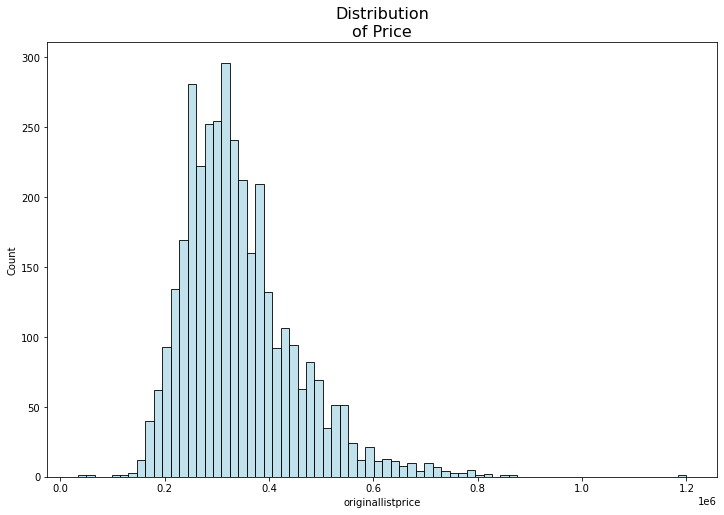

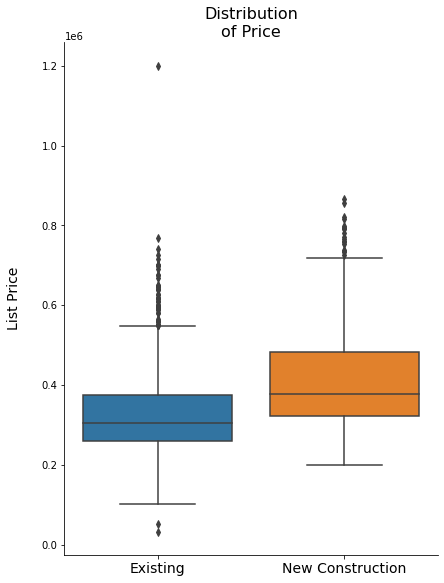

In [16]:
explore.difference_in_price(sale_df)

With the price being highly skewed, a median price is probably the best aggregate value. 

In [17]:
explore.show_median_prices(sale_df, target)

Median Price for New Construction: $ 377,700
Median Price for Existing: $ 305,000
Median difference in Price: $ 72,700


#### The median difference in price between new Construction and Existing is around $73,000 (for the city of San Antonio, June 2021 - July 2022)

### Price Per-SqFt

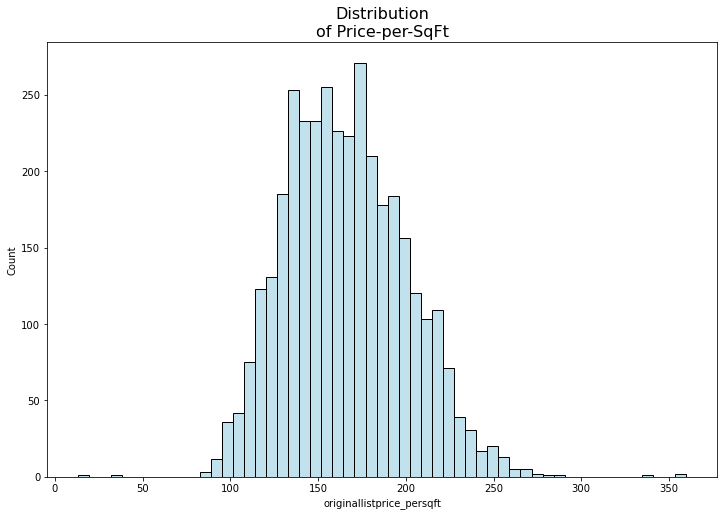

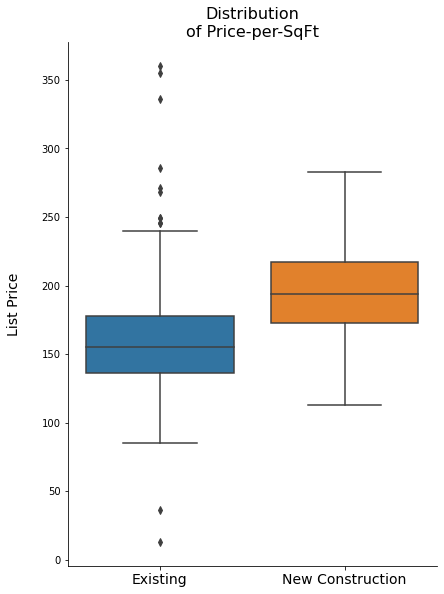

In [18]:
explore.difference_in_price_persqft(sale_df)

In [19]:
explore.show_median_price_persqft(sale_df, target)

Median Price-per-SqFt for New Construction: $ 194
Median Price-per-SqFt for Existing: $ 155
Median difference in Price-per-SqFt: $ 39


The per-sqft prices are not as skewed, so an average price could also represent this data appropriately, but I will stick with median here for consistency. 

The median difference in price-per-sqft between new construction and existing properties for this dataset is $39.